In [1]:
import pandas as pd                      
import datetime as dt                     
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from scipy.stats import shapiro                             # check normality
from scipy.stats import kstest                              # check stationary
from statsmodels.graphics.tsaplots import plot_acf          # plot auto correlation
from statsmodels.graphics.tsaplots import plot_pacf          
import warnings
warnings.filterwarnings('ignore')

C:\Users\84909\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('C:/Users/84909/Finpros/datasets/PNJ.csv', index_col ="Date/Time")

In [3]:
date_format = "%m/%d/%Y %H:%M"

In [4]:
df.index = pd.to_datetime(df.index, format = date_format)
df.drop(columns = 'Ticker', inplace = True)
df.head(5)

,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,
2018-02-28 09:15:00,78.14,78.99,78.14,78.99,270,0
2018-02-28 09:16:00,78.94,78.94,78.94,78.94,10,0
2018-02-28 09:19:00,78.14,78.14,78.14,78.14,283,0
2018-02-28 09:20:00,78.14,78.14,78.14,78.14,480,0
2018-02-28 09:21:00,78.14,78.14,78.14,78.14,146,0


In [5]:
df = df.resample('1D').mean().dropna()

In [6]:
df['log_returns'] = np.log(df.Close).diff()
df.dropna(inplace=True)

# Thống kê mô tả

Một số tham số thống kê giúp lựa chọn cổ phiếu đầu tư:

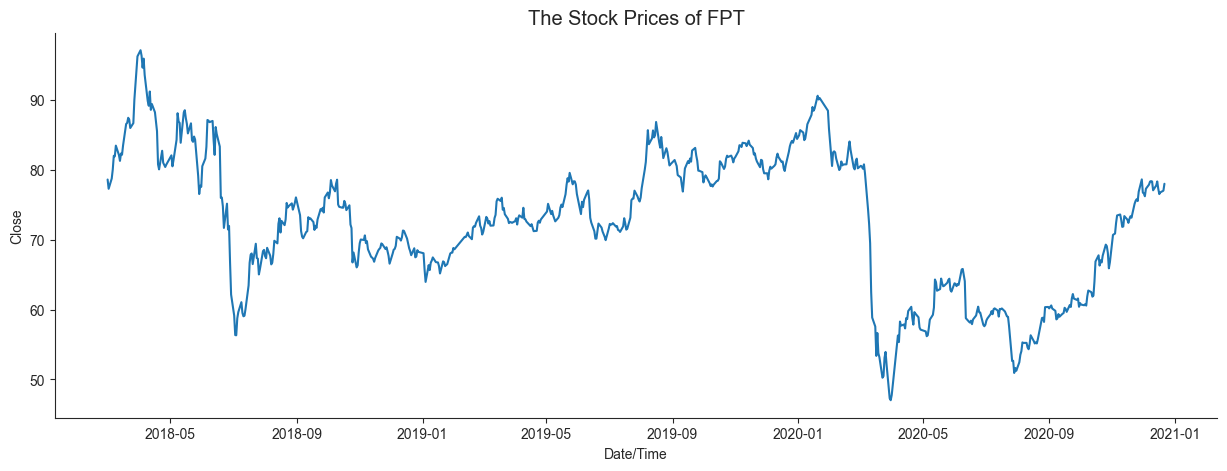

In [7]:
plt.figure(figsize=(15, 5))
sns.set_style("ticks")
sns.lineplot(data = df, x = "Date/Time", y = 'Close')
plt.title("The Stock Prices of FPT",size = 'x-large')
sns.despine()
plt.show()

Ta có thể thấy sự tăng trưởng trong giá cổ phiếu của FPT khá đều đặn từ 2019 đến tháng 1/2020. Sau đó giảm rất sâu 2-3 tháng và phục hồi lại từ tháng 4/2020.

In [8]:
# df.describe()

Trung bình returns của FPT cao nhất so với những cổ phiếu khác, độ lệch chuẩn không cao phù hợp với biểu đồ phía trên khi giá tăng đều đặn

In [9]:
# df.skew()

Tuy nhiên đầu tư chứng khoán luôn có rủi ro, nhìn chung lợi nhuận của tất cả cổ phiếu đều âm.

In [10]:
# df.kurtosis()

Độ kurtosis > 3 cho thấy khả năng xuất hiện outlier cao, đem lại rủi ro hoặc lợi nhuận lớn.

In [11]:
# sns.distplot(tuple(df.log_returns), kde=False, fit = st.norm)
# sns.despine()
# plt.show()

Ta nhận thấy dữ liệu có phân phối hình chuông, tuy nhiên chỉ số kurtosis > 3 nên đuôi của phân phối cao hơn so với phân phối chuẩn $\to$ phân phối Student.

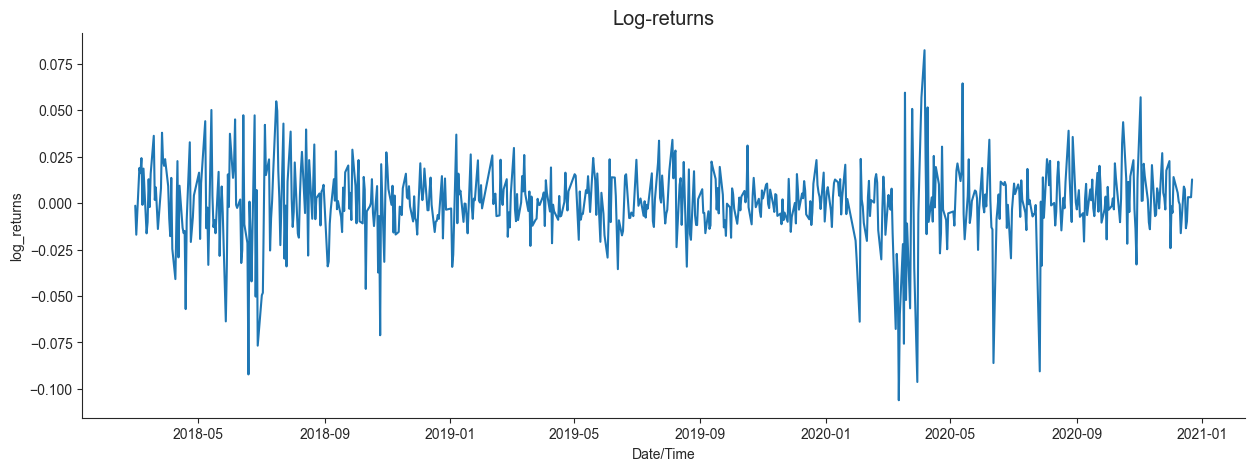

In [12]:
plt.figure(figsize=(15, 5))
sns.set_style("ticks")
sns.lineplot(data = df, x = "Date/Time", y = 'log_returns')
plt.title("Log-returns",size = 'x-large')
sns.despine()
plt.show()

Dựa vào log-returns có thể thấy chỉ số này có tính stationary, phương sai khá ổn định từ năm 2018-2020. Sau năm 2020 xuất hiện khá nhiều outlier

### 1. Kiểm tra tính chuẩn

##### Shapiro-Wilk Test

In [13]:
shapiro(df.log_returns)

ShapiroResult(statistic=0.9236802458763123, pvalue=1.8192915266720847e-18)

##### Kolmogorov-Smirnov Test

In [14]:
kstest(df.log_returns, 'norm')

KstestResult(statistic=0.47346636666761444, pvalue=3.1727050581207536e-146, statistic_location=0.059464110115849955, statistic_sign=1)

Vậy cả 2 phương pháp kiểm định đều cho kết quả p-value < 0.05, ta có đủ cơ sở để bác bỏ giả thuyết $H_0$, dữ liệu không có phân phối chuẩn

#### 2. Kiểm tra tính dừng - stationary

In [15]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

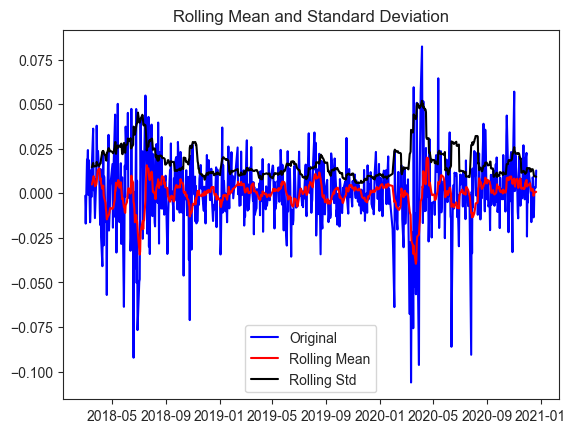

Results of dickey fuller test
Test Statistics               -1.602635e+01
p-value                        6.125421e-29
No. of lags used               1.000000e+00
Number of observations used    7.060000e+02
critical value (1%)           -3.439646e+00
critical value (5%)           -2.865643e+00
critical value (10%)          -2.568955e+00
dtype: float64


In [16]:
test_stationarity(df.log_returns)

- p-value < 0.05 nên giá trị log returns có tính dừng

## Kiểm tra AutoCorrelation

Ta cần kiểm tra tính tự tương quan để lựa chọn bậc mô hình phù hợp. Có 2 cách thường dùng để kiểm tra điều này:

- AR Plot: tự chọn số bậc phù hợp

- AIC / BIC

Kiểm tra sự tự tương quan trong vòng 10 ngày

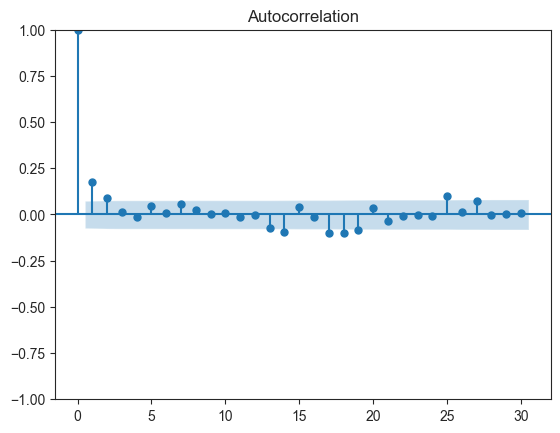

In [17]:
plot_acf(df['log_returns'], lags = 30)
plt.show()

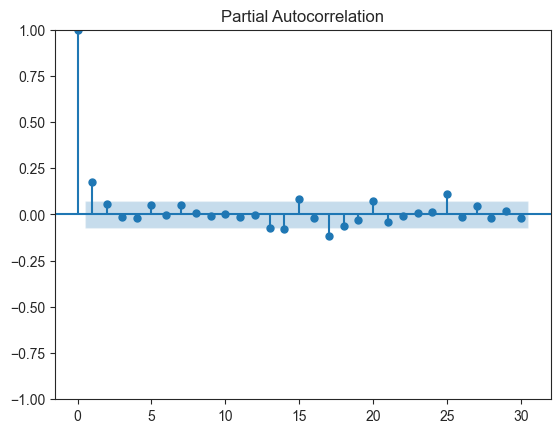

In [18]:
plot_pacf(df['log_returns'], lags = 30)
plt.show()

Nên ta có thể chọn lag term = 1

Để tìm mô hình tốt nhất dựa trên AIC, ta sử dụng package hỗ trợ:

In [19]:
X = df['log_returns']
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

In [20]:
model = auto_arima(train, start_p=0, start_q=0,
                   max_p=8, max_q=8, m=12,
                   start_P=0, seasonal=False,
                   d=1, D=0, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2489.744, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2616.788, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2491.744, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2654.958, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2673.747, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-2699.756, Time=0.63 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-2710.303, Time=0.51 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-2726.290, Time=0.44 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-2732.117, Time=0.51 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=-2732.937, Time=0.31 sec
 ARIMA(8,1,1)(0,0,0)[0] intercept   : AIC=-2734.802, Time=2.00 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=-2737.724, Time=1.80 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-2738.513, Time=1.48 sec
 ARIMA(5,1,1)(0,0,0)[0] i

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  566
Model:               SARIMAX(2, 1, 1)   Log Likelihood                1391.335
Date:                Sun, 05 May 2024   AIC                          -2772.670
Time:                        14:30:31   BIC                          -2750.986
Sample:                             0   HQIC                         -2764.206
                                - 566                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.742e-06   2.68e-05     -0.139      0.889   -5.63e-05    4.88e-05
ar.L1          0.1580      0.029      5.452      0.000       0.101       0.215
ar.L2          0.0698      0.034      2.034      0.042       0.003       0.137
ma.L1         -0.9759      0.009   -104.700      0.000      -0.994      -0.958
sigma2         0.0004   1.52e-05     26.827      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               246.35
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.28
Prob(H) (two-sided):                  0.13   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ta thấy các hệ số ước lượng đều có $(P > |z|) < 0.05$ điều này có nghĩa các hệ số đều có ý nghĩa về mặt thống kê. Ta chấp nhận mô hình này.

In [22]:
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    # Make the prediction
    output = model_fit.forecast(step = 1)
    yhat = output[0]
    return yhat

## Training

In [23]:
# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

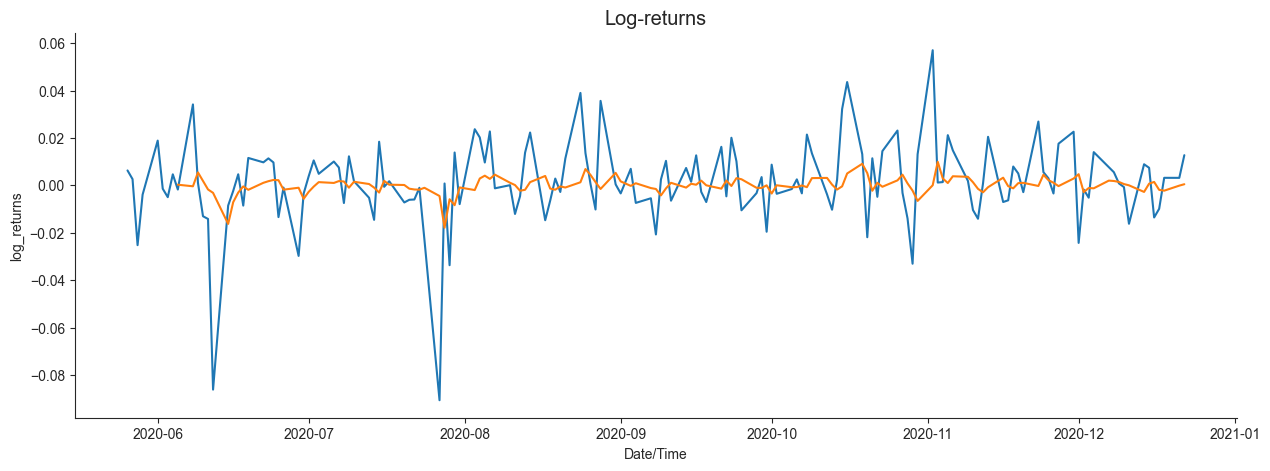

In [25]:
plt.figure(figsize=(15, 5))
sns.set_style("ticks")
sns.lineplot(data = df[-150:], x = "Date/Time", y = 'log_returns')
sns.lineplot(data = df[-142:], x = "Date/Time", y = predictions)
plt.title("Log-returns",size = 'x-large')
sns.despine()
plt.show()

In [26]:
from sklearn import metrics

In [27]:
binary_true = np.where(np.array(test) > 0, 1, 0)
binary_pred = np.where(np.array(predictions) > 0, 1, 0)

In [28]:
confusion_matrix = metrics.confusion_matrix(binary_true, binary_pred)

In [29]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

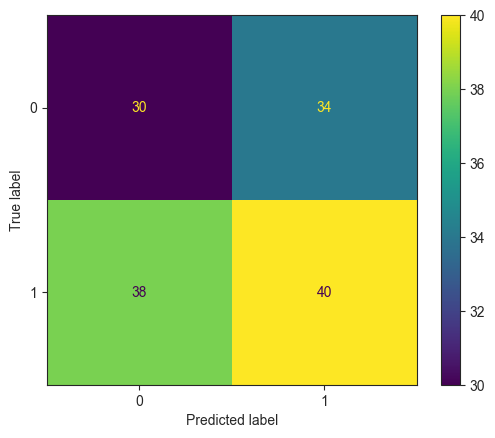

In [30]:
cm_display.plot()
plt.show()

In [31]:
def log_returns_to_close(log_returns, initial_close):
    close_prices = initial_close * np.exp(log_returns)
    return close_prices

In [32]:
initial_close = df.Close[-len(test)-1:-1]
close_pred = log_returns_to_close(predictions, initial_close)

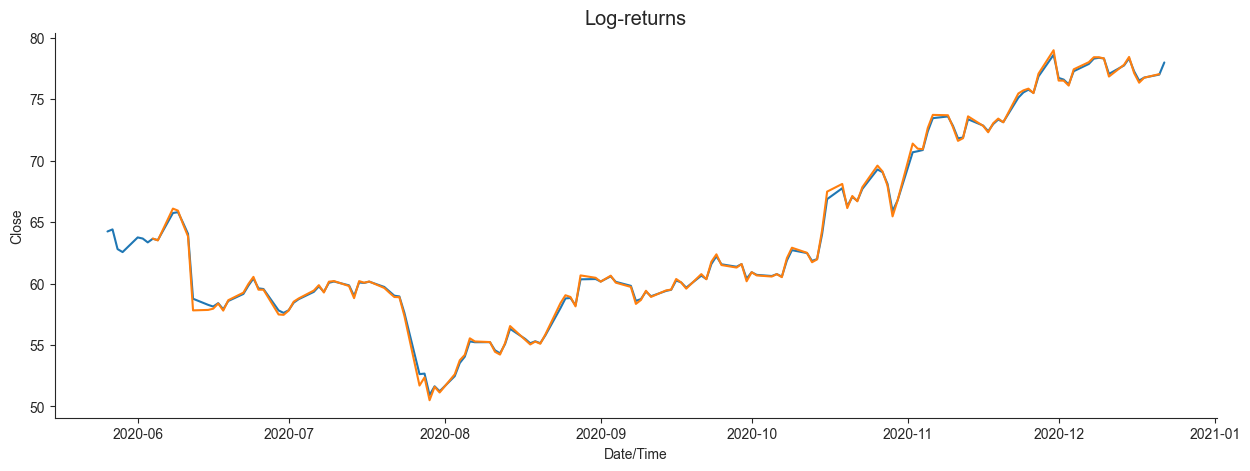

In [33]:
plt.figure(figsize=(15, 5))
sns.set_style("ticks")
sns.lineplot(data = df[-150:], x = "Date/Time", y = 'Close')
sns.lineplot(data = df[-150:], x = "Date/Time", y = close_pred)
plt.title("Log-returns",size = 'x-large')
sns.despine()
plt.show()

## Kiểm tra sai số của mô hình

Sai số của mô hình phải là nhiễu trắng (thông tin tốt / xấu) được đưa vào mô hình một cách ngẫu nhiên. 

Do đó ta kiểm định sai số của chúng ta có auto correlation

In [34]:
sm.stats.acorr_ljungbox(model.resid(), lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,4.347802,0.930296


p-value > 0.05 nên sai số của chúng ta hoàn toàn không có auto correlation.

## Inference

In [36]:
df = pd.read_csv('C:/Users/84909/Finpros/datasets/PNJ.csv', index_col ="Date/Time")

In [37]:
date_format = "%m/%d/%Y %H:%M"

In [38]:
df = df.drop(columns=['Ticker'])
df.index = pd.to_datetime(df.index, format = date_format)

In [39]:
df = df.resample('1D').mean().dropna()
df = pd.DataFrame(df['Close'])

In [40]:
df= np.log(df)
df.dropna(inplace=True)

In [41]:
predict_day = 7

In [42]:
train, test = df[:-predict_day], df[-predict_day:]

<Axes: xlabel='Date/Time'>

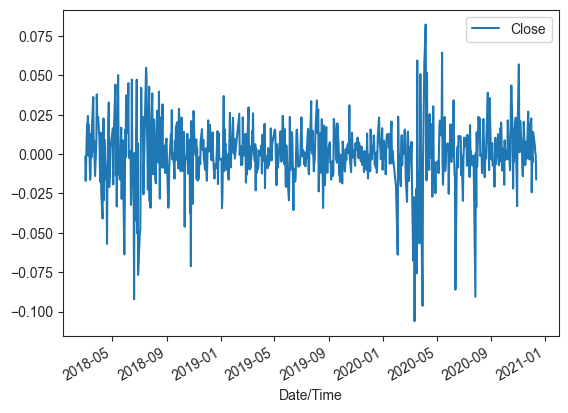

In [43]:
train_diff = train.diff().dropna()
train_diff.plot()

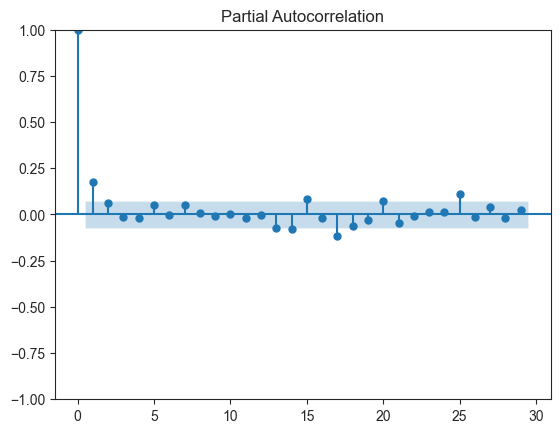

In [44]:
plot_pacf(train_diff)
plt.show()

In [46]:
model = auto_arima(train, start_p=0, start_q=0,
                   max_p=10, max_q=10, m=14,
                   start_P=0, seasonal=False,
                   d=1, D=0, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3470.739, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3491.289, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3488.344, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3472.738, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3491.858, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3489.983, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3489.843, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3491.340, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3487.947, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3493.856, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3493.288, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-3491.983, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3491.841, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3493.339, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0

<Axes: xlabel='Date/Time'>

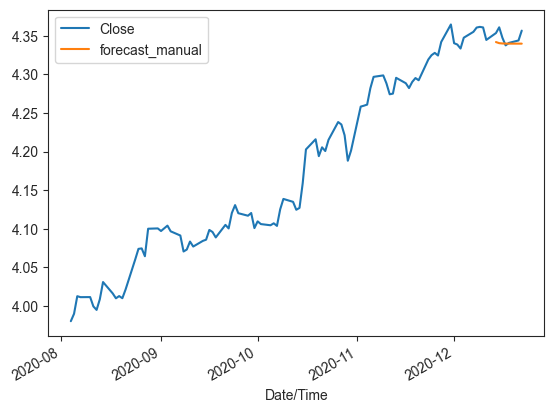

In [47]:
pred, conf = model.predict(n_periods = 7, return_conf_int = True)

df['forecast_manual'] = [None]*len(train) + list(pred)

df[-100:].plot()

<Axes: xlabel='Date/Time'>

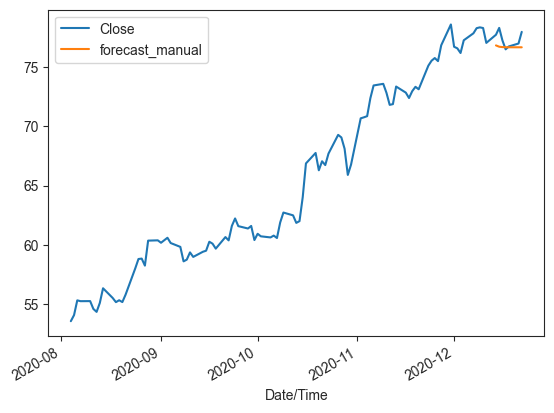

In [48]:
np.exp(df[-100:]).plot()

In [49]:
np.exp(conf[:, 0])

array([73.91089579, 72.27237257, 70.99030644, 69.94075618, 69.04305718,
       68.25181184, 67.53933131])

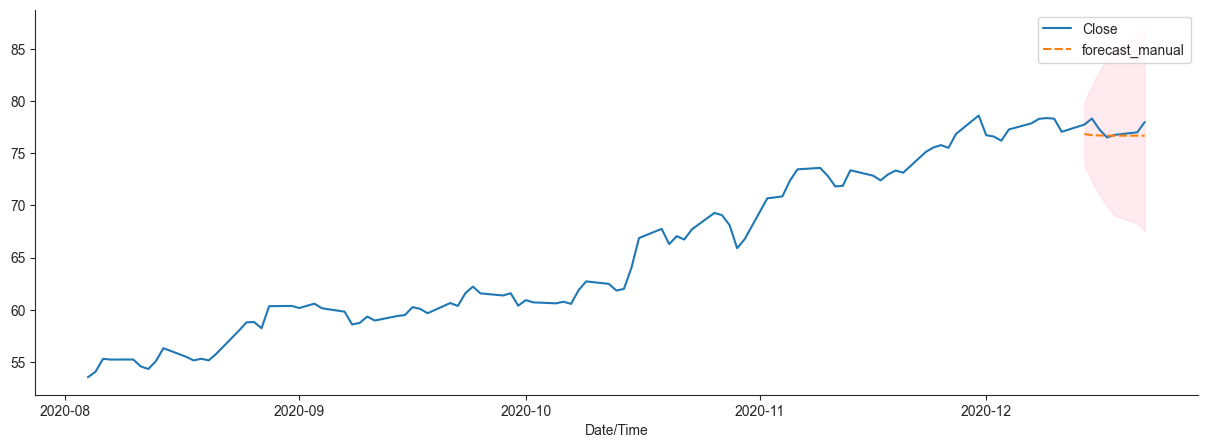

In [50]:
plt.figure(figsize=(15, 5))
sns.set_style("ticks")
sns.lineplot(data = np.exp(df[-100:]))
plt.fill_between(df[-7:].index, np.exp(conf[:, 0]), np.exp(conf[:, 1]), color='pink', alpha=0.3, label='95% Confidence Interval')
sns.despine()
plt.show()